# Conclusion as of Nov 16 2024
- Squared deviation score rewards "further from 50%" strategies more
- All scoring methods rank "spread" strategies the same
- Brier score and squared deviation have the same average rank position changes from baseline score
- Squared deviation scoring matches the brier score rankings better than baseline rankings
- Squared deviation score is the best deviation score available thus far 

# Update as of Nov 17 2024
- Expected log score is best analogy to baseline score when assuming community prediction is the true probability and the actual resolution is not yet known

In [2]:
from typing import Callable, Literal

import numpy as np
from pydantic import BaseModel

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)


class Question:
    def __init__(self, true_probability: float) -> None:
        assert 0.01 <= true_probability <= 0.99
        self.true_probability: float = true_probability
        self.resolution: bool = True if rng.random() < self.true_probability else False
        self.community_prediction: float = self.true_probability


class ScoringMethod(BaseModel):
    score_function: Callable[[Question, float], float]

    @property
    def name(self) -> str:
        return self.score_function.__name__


class Forecaster(BaseModel):
    prediction_strategy: Callable[[Question], float]
    name: str

    def predict(self, question: Question) -> float:
        return self.prediction_strategy(question)


class ForecasterPredictions:
    def __init__(self, forecaster: Forecaster, questions: list[Question]) -> None:
        self.forecaster = forecaster
        self.questions = questions
        self.predictions = [forecaster.predict(question) for question in questions]

    def get_average_score(self, scoring_method: ScoringMethod) -> float:
        scores = [
            scoring_method.score_function(q, p)
            for q, p in zip(self.questions, self.predictions)
        ]
        return float(np.average(scores))


class Ranking:
    def __init__(
        self,
        forecaster_predictions: list[ForecasterPredictions],
        scoring_method: ScoringMethod,
    ) -> None:
        self.scoring_method = scoring_method
        self.ranked_forecaster_predictions = sorted(
            forecaster_predictions,
            key=lambda x: x.get_average_score(self.scoring_method),
            reverse=True,
        )

    @property
    def ranked_forecasters(self) -> list[Forecaster]:
        return [fp.forecaster for fp in self.ranked_forecaster_predictions]

    @property
    def ranked_scores(self) -> list[float]:
        return [
            fp.get_average_score(self.scoring_method)
            for fp in self.ranked_forecaster_predictions
        ]


class Tournament:
    def __init__(
        self,
        questions: list[Question],
        forecasters: list[Forecaster],
        scoring_methods: list[ScoringMethod],
    ) -> None:
        forecaster_names = [f.name for f in forecasters]
        assert len(forecaster_names) == len(
            set(forecaster_names)
        ), "All forecasters must have unique names"

        self.questions = questions
        self.forecasters = forecasters
        self.scoring_methods = scoring_methods
        self.rankings = self.__get_rankings()

    def __get_rankings(self) -> list[Ranking]:
        forecaster_predictions = [
            ForecasterPredictions(forecaster, self.questions)
            for forecaster in self.forecasters
        ]
        rankings = [
            Ranking(forecaster_predictions, scoring_method)
            for scoring_method in self.scoring_methods
        ]
        return rankings


class QuestionManager:

    @classmethod
    def get_all_questions_sets(cls, num_questions_per_set: int) -> list[list[Question]]:
        return [
            cls.get_random_questions(num_questions_per_set),
            cls.get_uncertain_questions(num_questions_per_set),
            cls.get_certain_questions(num_questions_per_set),
            cls.get_low_probability_questions(num_questions_per_set),
            cls.get_high_probability_questions(num_questions_per_set),
        ]

    @classmethod
    def get_random_questions(cls, num_questions: int) -> list[Question]:
        return [
            Question(true_probability=rng.uniform(0.01, 0.99))
            for _ in range(num_questions)
        ]

    @classmethod
    def get_uncertain_questions(cls, num_questions: int) -> list[Question]:
        return [
            Question(true_probability=rng.uniform(0.1, 0.9))
            for _ in range(num_questions)
        ]

    @classmethod
    def get_certain_questions(cls, num_questions: int) -> list[Question]:
        return [
            Question(
                true_probability=(
                    rng.uniform(0.9, 0.99)
                    if rng.random() < 0.5
                    else rng.uniform(0.01, 0.1)
                )
            )
            for _ in range(num_questions)
        ]

    @classmethod
    def get_low_probability_questions(cls, num_questions: int) -> list[Question]:
        return [
            Question(true_probability=rng.uniform(0.01, 0.5))
            for _ in range(num_questions)
        ]

    @classmethod
    def get_high_probability_questions(cls, num_questions: int) -> list[Question]:
        return [
            Question(true_probability=rng.uniform(0.5, 0.99))
            for _ in range(num_questions)
        ]


class ScoringMethodCreator:
    @classmethod
    def get_all_scoring_methods(cls) -> list[ScoringMethod]:
        return [
            cls.brier_score(),
            cls.baseline_score(),
            cls.squared_deviation_score(),
            cls.exact_deviation_score(),
            cls.log_deviation_score(),
            cls.relative_entropy_score(),
            cls.ratio_score(),
            cls.geometric_mean_score(),
            cls.log_odds_ratio_score(),
            cls.squared_log_odds_ratio_score(),
            cls.expected_brier_score(),
            cls.expected_log_score(),
        ]

    @classmethod
    def baseline_score(cls) -> ScoringMethod:
        def baseline_scoring(question: Question, prediction: float) -> float:
            actual = 1.0 if question.resolution else 0.0
            outcome_prob = prediction if abs(actual - 1.0) < 1e-4 else (1 - prediction)
            return (np.log2(outcome_prob) + 1) * 100

        return ScoringMethod(score_function=baseline_scoring)

    @classmethod
    def brier_score(cls) -> ScoringMethod:
        def brier_scoring(question: Question, prediction: float) -> float:
            actual = 1.0 if question.resolution else 0.0
            return -((actual - prediction) ** 2)

        return ScoringMethod(score_function=brier_scoring)

    @classmethod
    def log_deviation_score(cls) -> ScoringMethod:
        def log_deviation_scoring(question: Question, prediction: float) -> float:
            return abs(np.log2(prediction) - np.log2(question.community_prediction)) * -1

        return ScoringMethod(score_function=log_deviation_scoring)

    @classmethod
    def squared_deviation_score(cls) -> ScoringMethod:
        def squared_deviation_scoring(question: Question, prediction: float) -> float:
            return abs(prediction - question.community_prediction) ** 2 * -1

        return ScoringMethod(score_function=squared_deviation_scoring)

    @classmethod
    def exact_deviation_score(cls) -> ScoringMethod:
        def exact_deviation_scoring(question: Question, prediction: float) -> float:
            return abs(prediction - question.community_prediction) * -1

        return ScoringMethod(score_function=exact_deviation_scoring)

    @classmethod
    def relative_entropy_score(cls) -> ScoringMethod:
        def relative_entropy_scoring(question: Question, prediction: float) -> float:
            p = prediction
            q = question.community_prediction
            return -(p * np.log2(p/q) + (1-p) * np.log2((1-p)/(1-q)))

        return ScoringMethod(score_function=relative_entropy_scoring)

    @classmethod
    def ratio_score(cls) -> ScoringMethod:
        def ratio_scoring(question: Question, prediction: float) -> float:
            return -abs(prediction / question.community_prediction - 1)

        return ScoringMethod(score_function=ratio_scoring)

    @classmethod
    def geometric_mean_score(cls) -> ScoringMethod:
        def geometric_mean_scoring(question: Question, prediction: float) -> float:
            return -abs(np.sqrt(prediction * (1-prediction)) -
                       np.sqrt(question.community_prediction * (1-question.community_prediction)))

        return ScoringMethod(score_function=geometric_mean_scoring)

    @classmethod
    def log_odds_ratio_score(cls) -> ScoringMethod:
        def log_odds_ratio_scoring(question: Question, prediction: float) -> float:
            p = prediction
            c = question.community_prediction
            log_odds_ratio = np.log((p / (1 - p)) / (c / (1 - c)))
            return -abs(log_odds_ratio)

        return ScoringMethod(score_function=log_odds_ratio_scoring)

    @classmethod
    def squared_log_odds_ratio_score(cls) -> ScoringMethod:
        def squared_log_odds_ratio_scoring(question: Question, prediction: float) -> float:
            p = prediction
            c = question.community_prediction
            log_odds_ratio = np.log((p / (1 - p)) / (c / (1 - c)))
            return -(log_odds_ratio ** 2)

        return ScoringMethod(score_function=squared_log_odds_ratio_scoring)

    @classmethod
    def expected_brier_score(cls) -> ScoringMethod:
        def expected_brier_scoring(question: Question, prediction: float) -> float:
            c = question.community_prediction
            p = prediction
            expected_score = c * (1 - p)**2 + (1 - c) * (1 - (1 - p))**2
            return -expected_score

        return ScoringMethod(score_function=expected_brier_scoring)

    @classmethod
    def expected_log_score(cls) -> ScoringMethod:
        def expected_log_scoring(question: Question, prediction: float) -> float:
            c = question.community_prediction
            p = prediction
            expected_score = c * np.log2(p) + (1 - c) * np.log2(1 - p)
            return expected_score

        return ScoringMethod(score_function=expected_log_scoring)


class ForecasterCreator:

    @classmethod
    def get_all_forecasters(cls) -> list[Forecaster]:
        return [
            cls.always_right_predictor(),
            cls.always_wrong_predictor(),
            *cls.get_all_non_omniscient_forecasters(),
        ]

    @classmethod
    def get_all_non_omniscient_forecasters(cls) -> list[Forecaster]:
        return [
            cls.random_predictor(),
            cls.true_probability_predictor(),
            cls.always_predict_50_percent(),
            cls.randomly_below_50_percent(),
            cls.randomly_above_50_percent(),
            *cls.random_spread_predictors(10),
            *cls.over_or_under_confidence_predictors(5, "closer"),
            *cls.over_or_under_confidence_predictors(5, "further"),
            *cls.fixed_bias_predictors(10),
        ]

    @classmethod
    def random_predictor(cls) -> Forecaster:
        def randomly_predict(question: Question) -> float:
            return rng.random()

        return Forecaster(prediction_strategy=randomly_predict, name="Random Predictor")

    @classmethod
    def true_probability_predictor(cls) -> Forecaster:
        def predict_true_probability(question: Question) -> float:
            return question.true_probability

        return Forecaster(
            prediction_strategy=predict_true_probability, name="True Probability"
        )

    @classmethod
    def always_right_predictor(cls) -> Forecaster:
        def predict_perfect(question: Question) -> float:
            return 0.99 if question.resolution == True else 0.01

        return Forecaster(prediction_strategy=predict_perfect, name="Always Right")

    @classmethod
    def always_wrong_predictor(cls) -> Forecaster:
        def predict_always_wrong(question: Question) -> float:
            return 0.01 if question.resolution == True else 0.99

        return Forecaster(prediction_strategy=predict_always_wrong, name="Always Wrong")

    @classmethod
    def always_predict_50_percent(cls) -> Forecaster:
        def predict_50_percent(question: Question) -> float:
            return 0.5

        return Forecaster(prediction_strategy=predict_50_percent, name="Always 50%")

    @classmethod
    def randomly_below_50_percent(cls) -> Forecaster:
        def predict_randomly_below_50_percent(question: Question) -> float:
            return rng.uniform(0.01, 0.5)

        return Forecaster(
            prediction_strategy=predict_randomly_below_50_percent,
            name="Randomly Below 50%",
        )

    @classmethod
    def randomly_above_50_percent(cls) -> Forecaster:
        def predict_randomly_above_50_percent(question: Question) -> float:
            return rng.uniform(0.5, 0.99)

        return Forecaster(
            prediction_strategy=predict_randomly_above_50_percent,
            name="Randomly Above 50%",
        )

    @classmethod
    def random_spread_predictors(cls, num_predictors: int) -> list[Forecaster]:
        skill_levels_spaced_out = np.linspace(0, 1, num_predictors, endpoint=False)

        def predict_with_skill_level(question: Question, skill_level: float) -> float:
            adjusted_skill_level = 1.5 - (
                skill_level * 1.5
            )  # Scale it to at max 1.5 and invert it. 1.5 chosen from manual experimentation. Lower value will lead to lower spread.
            return cls.__clip_prediction(
                rng.normal(question.true_probability, adjusted_skill_level)
            )

        forecasters = []
        for skill_level in skill_levels_spaced_out:
            forecasters.append(
                Forecaster(
                    prediction_strategy=lambda q, skill_level=skill_level: predict_with_skill_level(
                        q, skill_level
                    ),
                    name=f"Spread: Skill level {skill_level:.2f}",
                )
            )

        return forecasters

    @classmethod
    def over_or_under_confidence_predictors(
        cls, num_predictors: int, bias_to_50_percent: Literal["closer", "further"]
    ) -> list[Forecaster]:
        skill_levels = np.linspace(0, 1, num_predictors, endpoint=False)

        def predict_with_random_bias(
            question: Question,
            skill_level: float,
            bias_to_50_percent: Literal["closer", "further"],
        ) -> float:
            base_prediction = question.true_probability
            base_pred_above_50_percent = base_prediction > 0.5

            if bias_to_50_percent == "closer":
                max_allowed_delta = abs(base_prediction - 0.5)
                add_or_subract_multiplier = -1 if base_pred_above_50_percent else 1
                assert (
                    abs(
                        base_prediction
                        + max_allowed_delta * add_or_subract_multiplier
                        - 0.5
                    )
                    < 0.01
                )
            elif bias_to_50_percent == "further":
                max_allowed_delta = 1 - abs(base_prediction - 0.5)
                add_or_subract_multiplier = 1 if base_pred_above_50_percent else -1
                zero_or_one_value = (
                    base_prediction + max_allowed_delta * add_or_subract_multiplier
                )
                assert zero_or_one_value < 0.01 or zero_or_one_value > 0.99

            scaled_max_delta = max_allowed_delta * (1 - skill_level)
            random_delta_based_on_skill = (
                rng.uniform(0, scaled_max_delta) * add_or_subract_multiplier
            )
            prediction = base_prediction + random_delta_based_on_skill
            clipped_prediction = cls.__clip_prediction(prediction)
            return clipped_prediction

        forecasters = []
        for i, skill_level in enumerate(skill_levels):
            forecasters.append(
                Forecaster(
                    prediction_strategy=lambda q, skill_level=skill_level: predict_with_random_bias(
                        q, skill_level, bias_to_50_percent
                    ),
                    name=f"Confidence: Skill level {skill_level:.2f} (errors {bias_to_50_percent} to 50%)",
                )
            )

        return forecasters

    @classmethod
    def fixed_bias_predictors(cls, num_predictors: int) -> list[Forecaster]:
        bias_levels = np.linspace(-0.45, 0.5, num_predictors)

        def predict_x_percentage_points_higher_than_true_probability(
            question: Question, x: float
        ) -> float:
            return cls.__clip_prediction(question.true_probability + x)

        forecasters = []
        for bias in bias_levels:
            forecasters.append(
                Forecaster(
                    prediction_strategy=lambda q, bias=bias: predict_x_percentage_points_higher_than_true_probability(
                        q, bias
                    ),
                    name=f"Fixed Bias: Deviate by {bias*100:.2f}% points",
                )
            )

        return forecasters

    @classmethod
    def __clip_prediction(cls, prediction: float) -> float:
        return np.clip(prediction, 0.01, 0.99)




/tmp/ipykernel_981/976794651.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=scores, y=names, ax=ax, palette='viridis')
/tmp/ipykernel_981/976794651.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=scores, y=names, ax=ax, palette='viridis')
/tmp/ipykernel_981/976794651.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=scores, y=names, ax=ax, palette='viridis')
/tmp/ipykernel_981/976794651.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assi

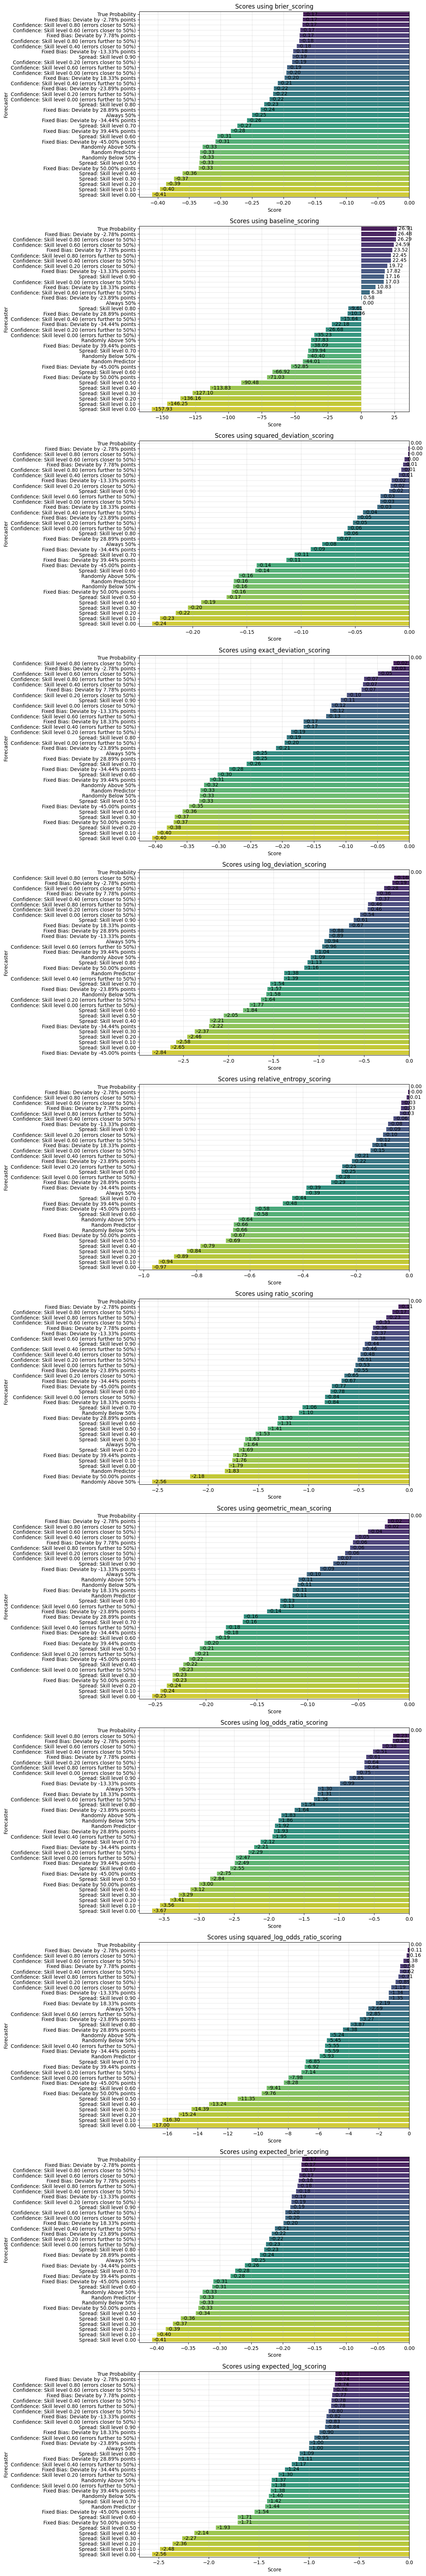

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
questions = QuestionManager.get_random_questions(10000)

tournament = Tournament(
    questions=questions,
    forecasters=[
        # *ForecasterCreator.get_all_forecasters()
        *ForecasterCreator.get_all_non_omniscient_forecasters()
    ],
    scoring_methods=ScoringMethodCreator.get_all_scoring_methods(),
)

def visualize_tournament_results(tournament: Tournament) -> None:
    num_scoring_methods = len(tournament.scoring_methods)
    fig, axes = plt.subplots(num_scoring_methods, 1, figsize=(12, 6 * num_scoring_methods))
    if num_scoring_methods == 1:
        axes = [axes]

    for ax, ranking in zip(axes, tournament.rankings):
        scores = ranking.ranked_scores
        names = [f.name for f in ranking.ranked_forecasters]

        bars = sns.barplot(x=scores, y=names, ax=ax, palette='viridis')

        if isinstance(bars, int):
            raise ValueError("this is just to use the var 'bars' for sake of the ruff formatter")

        # Add value labels next to each bar
        for i, score in enumerate(scores):
            ax.text(score, i, f' {score:.2f}', va='center')

        ax.set_title(f'Scores using {ranking.scoring_method.name}')
        ax.set_xlabel('Score')
        ax.set_ylabel('Forecaster')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_tournament_results(tournament)

In [ ]:
def visualize_ranking_differences(tournament: Tournament) -> None:
    # Get all scoring method names
    scoring_methods = [r.scoring_method.name for r in tournament.rankings]
    n_methods = len(scoring_methods)

    # Create a matrix of ranking differences
    diff_matrix = np.zeros((n_methods, n_methods))

    # For each pair of scoring methods
    for i, ranking1 in enumerate(tournament.rankings):
        ranks1 = {forecaster.name: rank for rank, forecaster in enumerate(ranking1.ranked_forecasters)}

        for j, ranking2 in enumerate(tournament.rankings):
            ranks2 = {forecaster.name: rank for rank, forecaster in enumerate(ranking2.ranked_forecasters)}

            # Calculate average absolute difference in rankings
            rank_diffs = [abs(ranks1[name] - ranks2[name]) for name in ranks1.keys()]
            diff_matrix[i, j] = np.mean(rank_diffs)

    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        diff_matrix,
        annot=True,
        fmt='.1f',
        xticklabels=scoring_methods,
        yticklabels=scoring_methods,
        cmap='YlOrRd'
    )
    plt.title('Average Absolute Difference in Rankings Between Scoring Methods')
    plt.xlabel('Scoring Method')
    plt.ylabel('Scoring Method')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_ranking_differences(tournament)

In [ ]:
def visualize_ranking_diffs(tournament: Tournament) -> None:
    # Get baseline score rankings as reference
    baseline_ranking = next(r for r in tournament.rankings if r.scoring_method.name == 'baseline_scoring')
    baseline_ranks = {f.name: i for i, f in enumerate(baseline_ranking.ranked_forecasters)}

    # Get ordered list of forecaster names from baseline (reversed to put best at top)
    baseline_ordered_names = [f.name for f in baseline_ranking.ranked_forecasters][::-1]

    # Create figure with a subplot for each non-baseline scoring method
    non_baseline_rankings = [r for r in tournament.rankings if r.scoring_method.name != 'baseline_scoring']
    fig, axes = plt.subplots(
        len(non_baseline_rankings), 1,
        figsize=(12, 8 * len(non_baseline_rankings)),
        squeeze=False
    )

    # For each scoring method
    for idx, ranking in enumerate(non_baseline_rankings):
        ax = axes[idx, 0]

        # Calculate position changes
        current_ranks = {f.name: i for i, f in enumerate(ranking.ranked_forecasters)}
        position_changes = {
            name: baseline_ranks[name] - current_ranks[name]
            for name in baseline_ranks
        }

        # Create list of changes in baseline order
        sorted_changes = [(name, position_changes[name]) for name in baseline_ordered_names]

        # Create colors and positions for bars
        colors = ['red' if change < 0 else 'green' for name, change in sorted_changes]
        y_pos = np.arange(len(sorted_changes)) * 2.0

        # Plot horizontal bars
        bars = ax.barh(
            y_pos,
            [change for _, change in sorted_changes],
            height=0.6,
            color=colors,
            alpha=0.6
        )

        # Add labels and formatting
        ax.set_yticks(y_pos)
        ax.set_yticklabels([name for name, _ in sorted_changes], fontsize=8)
        ax.set_title(
            f'Ranking Changes: {ranking.scoring_method.name} vs Baseline Score\n' +
            '(green = ranked higher in this scoring method than baseline, red = ranked lower)',
            pad=20, fontsize=12
        )
        ax.set_xlabel('Position Change', fontsize=10)
        ax.grid(True, alpha=0.3)

        # Add value labels on bars
        for i, bar in enumerate(bars):
            width = bar.get_width()
            if width != 0:  # Only add label if there's a change
                ax.text(
                    width + np.sign(width) * 0.5,
                    bar.get_y() + bar.get_height()/2,
                    f'{int(abs(width))} ranks {"higher" if width > 0 else "lower"}',
                    ha='left' if width > 0 else 'right',
                    va='center',
                    fontsize=8
                )

        # Adjust plot limits to show all labels
        ax.set_ylim(min(y_pos) - 2, max(y_pos) + 2)

    plt.tight_layout(pad=4.0)
    plt.show()

# Call the visualization function
visualize_ranking_diffs(tournament)

In [30]:

############################################# TESTS ##############################################


def test_brier_score_gives_correct_output() -> None:
    question = Question(true_probability=0.7)
    question.resolution = True
    scoring = ScoringMethodCreator.brier_score()

    perfect_prediction = 1.0
    perfect_score = scoring.score_function(question, perfect_prediction)
    assert abs(perfect_score) < 1e-10

    worst_prediction = 0.0
    worst_score = scoring.score_function(question, worst_prediction)
    assert abs(worst_score + 1.0) < 1e-10


def test_baseline_score_gives_correct_output() -> None:
    scoring = ScoringMethodCreator.baseline_score()
    test_cases = [
        (0.70, 48, -74),
        (0.80, 68, -132),
        (0.90, 85, -232),
        (0.99, 99, -564),
    ] # https://www.metaculus.com/help/scores-faq/#:~:text=was%20right%3F%20below.-,Can%20I%20get%20better%20scores%20by%20predicting%20extreme%20values%3F,-Metaculus%20uses%20proper

    for prediction, yes_score, no_score in test_cases:
        question = Question(true_probability=prediction)

        # Test when resolution is True
        question.resolution = True
        score_if_yes = scoring.score_function(question, prediction)
        yes_diff = abs(score_if_yes - yes_score)
        assert yes_diff < 1, f"Failed for p={prediction}, yes case. Diff: {yes_diff}. Score: {score_if_yes}. Expected: {yes_score}"

        # Test when resolution is False
        question.resolution = False
        score_if_no = scoring.score_function(question, prediction)
        no_diff = abs(score_if_no - no_score)
        assert no_diff < 1, f"Failed for p={prediction}, no case. Diff: {no_diff}. Score: {score_if_no}. Expected: {no_score}"




def test_skill_level_predictors_in_right_order() -> None:
    questions = QuestionManager.get_random_questions(10000)
    predictors = ForecasterCreator.random_spread_predictors(5)

    tournament = Tournament(
        questions=questions,
        forecasters=predictors,
        scoring_methods=[ScoringMethodCreator.brier_score()],
    )

    initial_predictors_sorted_by_skill = sorted(predictors, key=lambda x: x.name, reverse=True)
    final_ranked_predictors = tournament.rankings[0].ranked_forecasters

    for initial_predictor, final_predictor in zip(initial_predictors_sorted_by_skill, final_ranked_predictors):
        assert (
            initial_predictor.name == final_predictor.name
        ), (
            f"Predictor {initial_predictor.name} is not in the right order. Expected {final_predictor.name}. "
            f"Final rankings: {[f.name for f in final_ranked_predictors]}"
        )


def test_question_resolution_matches_true_probability() -> None:
    num_trials = 10000
    true_prob = 0.7
    questions = [Question(true_probability=true_prob) for _ in range(num_trials)]
    resolutions = [q.resolution for q in questions]
    actual_prob = sum(resolutions) / num_trials
    assert abs(actual_prob - true_prob) < 0.02, f"Actual probability of resolution is {actual_prob}, expected {true_prob}"


def test_fixed_bias_predictors_maintain_correct_bias() -> None:
    questions = QuestionManager.get_random_questions(1000)
    biased_predictor = ForecasterCreator.fixed_bias_predictors(5)


    for predictor in biased_predictor:
        predictions = [predictor.predict(q) for q in questions]
        true_probs = [q.true_probability for q in questions]

        should_be_higher = predictions[0] - true_probs[0] > 0
        for prediction, true_probability in zip(predictions, true_probs):
            if should_be_higher:
                assert prediction >= true_probability, (
                    f"Predictor {predictor.name} is not maintaining the correct bias. Expected higher prediction than true probability."
                    f"Prediction: {prediction}, True probability: {true_probability}"
                )
            else:
                assert prediction <= true_probability, (
                    f"Predictor {predictor.name} is not maintaining the correct bias. Expected lower prediction than true probability."
                    f"Prediction: {prediction}, True probability: {true_probability}"
                )


def test_over_confidence_predictors_move_away_from_50() -> None:
    questions = [Question(true_probability=0.7) for _ in range(100)]
    over_confident = ForecasterCreator.over_or_under_confidence_predictors(
        1, "further"
    )[0]

    predictions = [over_confident.predict(q) for q in questions]
    avg_prediction = sum(predictions) / len(predictions)

    assert avg_prediction > 0.7


def test_under_confidence_predictors_move_toward_50() -> None:
    questions = [Question(true_probability=0.7) for _ in range(100)]
    under_confident = ForecasterCreator.over_or_under_confidence_predictors(
        1, "closer"
    )[0]

    predictions = [under_confident.predict(q) for q in questions]
    avg_prediction = sum(predictions) / len(predictions)

    assert avg_prediction < 0.7

def test_predictors_score_in_obvious_order() -> None:
    questions = QuestionManager.get_random_questions(1000)

    tournament = Tournament(
        questions=questions,
        forecasters=[
            ForecasterCreator.true_probability_predictor(),
            ForecasterCreator.always_predict_50_percent(),
            ForecasterCreator.randomly_above_50_percent(),
        ],
        scoring_methods=ScoringMethodCreator.get_all_scoring_methods(),
    )

    for ranking in tournament.rankings:
        ranked_names = [f.name for f in ranking.ranked_forecasters]
        assert ranked_names[0] == "True Probability"
        assert ranked_names[1] == "Always 50%"
        assert ranked_names[2] == "Randomly Above 50%"


def test_all_question_sets_predictors_and_scoring_methods_get_same_ordering() -> None:
    question_sets = QuestionManager.get_all_questions_sets(1000)
    for question_set in question_sets:
        tournament = Tournament(
            questions=question_set,
            forecasters=ForecasterCreator.get_all_non_omniscient_forecasters(),
            scoring_methods=ScoringMethodCreator.get_all_scoring_methods(),
        )

        first_ranking_names = [f.name for f in tournament.rankings[0].ranked_forecasters]
        for ranking in tournament.rankings[1:]:
            current_ranking_names = [f.name for f in ranking.ranked_forecasters]
            assert first_ranking_names == current_ranking_names, (
                f"Rankings differ between scoring methods for question set. "
                f"First ranking: {first_ranking_names}, "
                f"Current ranking ({ranking.scoring_method.name}): {current_ranking_names}"
            )





In [31]:
test_brier_score_gives_correct_output()
test_baseline_score_gives_correct_output()
test_skill_level_predictors_in_right_order()
test_question_resolution_matches_true_probability()
test_fixed_bias_predictors_maintain_correct_bias()
test_over_confidence_predictors_move_away_from_50()
test_under_confidence_predictors_move_toward_50()
test_predictors_score_in_obvious_order()
# test_all_question_sets_predictors_and_scoring_methods_get_same_ordering()
